In [1]:
import PyDAQmx
import pyvisa
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm

In [2]:
def read_magnetometer():
    with PyDAQmx.Task() as task:
        # initialize the three channels
        for ch in [b'/Dev1/ai1', b'/Dev1/ai2', b'/Dev1/ai3']:
            task.CreateAIVoltageChan(
                physicalChannel       = ch,
                nameToAssignToChannel = "",
                terminalConfig        = PyDAQmx.DAQmx_Val_RSE,
                minVal                = 0.0,
                maxVal                = 1.0,
                units                 = PyDAQmx.DAQmx_Val_Volts,
                customScaleName       = None)
        
        # select timing type
        task.SetSampTimingType(PyDAQmx.DAQmx_Val_OnDemand)
        
        # array for return values
        result = np.zeros((3,), dtype=np.float64)
        read = PyDAQmx.int32()
    
        # start task and read values
        task.StartTask()
        task.ReadAnalogF64(
            numSampsPerChan  = 1,
            timeout          = 1.0,
            fillMode         = PyDAQmx.DAQmx_Val_GroupByChannel,
            arraySizeInSamps = 3,
            readArray        = result,
            sampsPerChanRead = PyDAQmx.byref(read),
            reserved         = None)

    return result

In [3]:
class Motor:
    def __init__(self):
        # connect to the Arduino
        self.rm = pyvisa.ResourceManager()
        self.instr = self.rm.open_resource(self.rm.list_resources()[0])
        self.instr.write_termination = "\n"
        self.instr.timeout = 2000
        self.instr.baud_rate = 115200
        
        # parse all messages
        try:
            while True:
                self.instr.read()
        except pyvisa.VisaIOError as err:
            pass
    
        # turn motor on
        self.instr.query("xon")
        self.instr.query("s1000") # set speed
    
    def move(self, position):
        # send motion commands
        self.instr.query("x" + str(position))  # set desired motor position
        self.instr.query("mx")  # move motor to that position
    
    def setSpeed(self, speed):
        self.instr.query("s"+str(speed))
        
    def motorOn(self):
        self.instr.query("xon")
        
    def motorOff(self):
        self.instr.query("xoff")

In [22]:
# initialize the stepper motor
m = Motor()
m.setSpeed(300)
m.motorOff()
direction = 1

In [24]:
m.motorOn()
m.move(-10000)
m.motorOff()

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [ ]:
# initial / final point (in feet)
i0, i1 = [0, -3.8][::direction]

# for measurement results
results = []

for i in tqdm(range(int(i0*12*4), int(i1*12*4), -direction)):
    # move the sensor
    m.motorOn()
    m.move(i * 400 * 20 / 4)
    
    # give the motor some rest
    m.motorOff()
    time.sleep(1)
    
    # measure the magnetic field
    results.append(read_magnetometer())

m.motorOff()
direction *= -1

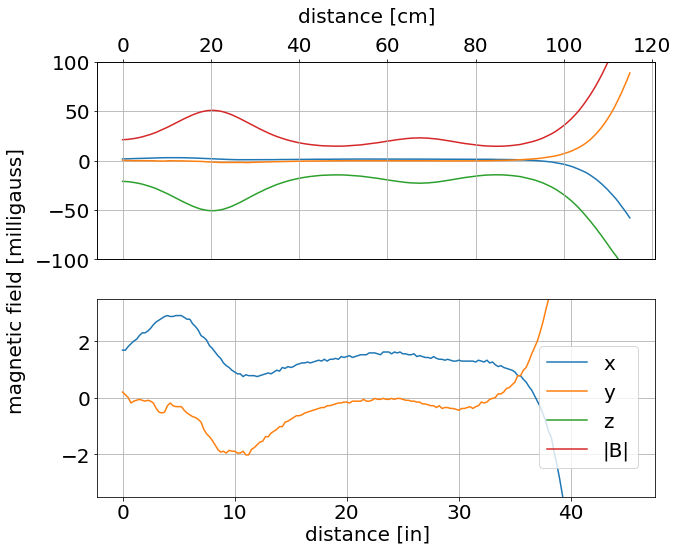

In [41]:
res = results
x = np.arange(*([0, len(res)][::direction]), direction)/4;
y = np.array(res) * 0.1 * 1000;
np.savetxt("7jun2019-6.csv", res);

# plot format
plt.rc('font', family='sans', size=20);
f, axarr = plt.subplots(2, figsize=(10,8), sharex=False);
axarr[0].grid();
axarr[1].grid();
ax2 = axarr[0].twiny()
ax2.xaxis.tick_top()
ax2.grid()
axarr[0].xaxis.set_visible(False)

# plot data
axarr[0].plot(x, y[:,0], label="x");
axarr[0].plot(x, y[:,1], label="y");
axarr[0].plot(x, y[:,2], label="z");
axarr[0].plot(x, np.sqrt(y[:,0]**2 + y[:,1]**2 + y[:,2]**2), label="|B|");
axarr[1].plot(x, y[:,0], label="x");
axarr[1].plot(x, y[:,1], label="y");
axarr[1].plot(x, y[:,2], label="z");
axarr[1].plot(x, np.sqrt(y[:,0]**2 + y[:,1]**2 + y[:,2]**2), label="|B|");

# plot labels
handles, labels = axarr[1].get_legend_handles_labels()
f.legend(handles, labels, loc=(0.79,.15))
f.text(0.0, 0.5, 'magnetic field [milligauss]', va='center', rotation='vertical')
f.text(0.5, .95, 'distance [cm]', ha='center', rotation='horizontal')
f.text(0.5, .05, 'distance [in]', ha='center', rotation='horizontal')

# plot data range
ax2.set_xlim([x*2.54 for x in axarr[0].get_xlim()])
axarr[0].set_ylim([-100,100]);
axarr[1].set_ylim([-3.5,3.5]);

# indicate the shielded region
# axarr[0].text(6.9,-0.53*1000,"shielded region");
# for i in range(2):
#     axarr[i].add_patch(Rectangle((-2.5, -500), 18.5, 2000,alpha=.2));
#     axarr[i].add_patch(Rectangle((18.5-2.5, -500), 18.5, 2000,alpha=.2,color="red"));